## Set-up

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import nltk
import string
import contractions 
import operator
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michalinabijak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michalinabijak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michalinabijak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michalinabijak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='white', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.5) 

## Data downloading and set-up

In [5]:
test_queries = pd.read_csv("/.../dataset/test-queries.tsv", sep="\t", header=None)
passages = pd.read_csv("/.../dataset/passage_collection_new.txt", sep="\t", header=None)
candidate = pd.read_csv(".../dataset/candidate_passages_top1000.tsv", sep="\t", header=None)

In [6]:
# rename columns
test_queries.columns=["qid", "query"]
passages.columns=["passage"]
candidate.columns=["qid", "pid", "query", "passage"]

In [7]:
# helper function, flattens a list of lists
flatten = lambda t: [item for sublist in t for item in sublist]

## Zipf's Law: pre-processing, ML parameter estimation and verification 
(Note: not all plots present have been used in the report)

In [8]:
from scipy import optimize
from scipy.stats import linregress

In [9]:
#contract, tokenize and remove punctuation
#full_text = [contractions.fix(sentence) for sentence in passages.passage]
full_text = [sentence for sentence in passages.passage]
full_text = flatten([nltk.word_tokenize(word) for word in full_text])
full_text = [word.lower() for word in full_text if word.isalpha()]

In [10]:
# frequency distribution of full text
fdist = nltk.FreqDist(full_text)

In [11]:
# get tokens, frequencies and probabilities sorted in descending order
tokens = np.array(sorted(fdist.keys(), key = fdist.get, reverse=True))
frequencies = np.array(sorted(fdist.values(), reverse=True))
probabilities = np.array(sorted(fdist.values(), reverse=True)) / fdist.N()

In [12]:
# define a Maximum Likelihood Estimator for parameter c, based on square error between estimated (c/rank) and true probability
def MLE(c):
    mle = 0
    for i in range(5000):
        mle += np.log((probabilities[i] - c/(i+1))**2)
    return mle

In [13]:
# minimise the ML to get the ML estimate
c = optimize.minimize(MLE, x0 = 0.5)

In [14]:
# probabilities fitted by Zipf's law, using ML estimate
fitted = np.array([c.x/(i+1) for i in range(len(probabilities))])
#zipf's law parameter estimates
zipfs = np.array([probabilities[i]*(i+1) for i in range(len(probabilities))])

In [15]:
mean = np.mean(zipfs)
sd = np.std(zipfs)

In [16]:
mean_fitted = np.array([np.mean(zipfs)/(i+1) for i in range(len(probabilities))])

In [17]:
linregress(probabilities, mean_fitted)

LinregressResult(slope=0.3130482460362021, intercept=-1.8543807492270835e-07, rvalue=0.9715469216059108, pvalue=0.0, stderr=0.00023194964250137956)

In [18]:
linregress(probabilities, fitted.reshape(-1,))

LinregressResult(slope=1.3697760618526305, intercept=-8.114041180597551e-07, rvalue=0.9715469216059109, pvalue=0.0, stderr=0.001014920453561405)

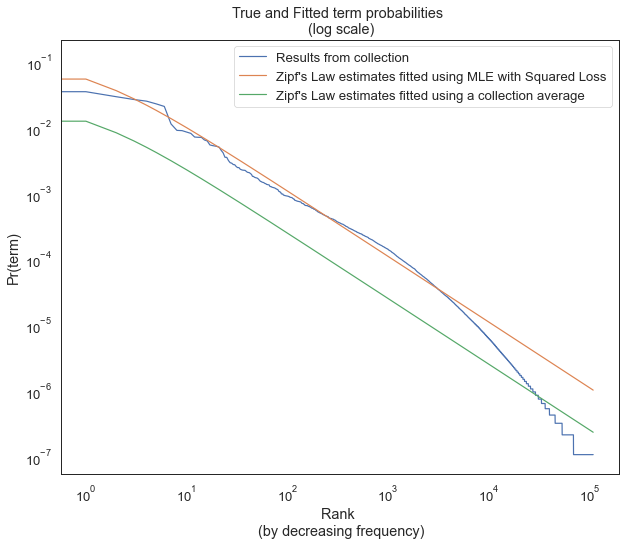

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(probabilities, label = "Results from collection")
#ax.plot(np.log(estimates1[:5000]), label = "Zipf's law estimates with parameter c=0.1")
ax.plot(fitted, label = "Zipf's Law estimates fitted using MLE with Squared Loss")
ax.plot(mean_fitted, label = "Zipf's Law estimates fitted using a collection average ")
plt.xlabel("Rank \n (by decreasing frequency)")
plt.ylabel('Pr(term)')
plt.title("True and Fitted term probabilities \n (log scale)")
plt.xscale("log")
plt.yscale("log")

ax.legend()

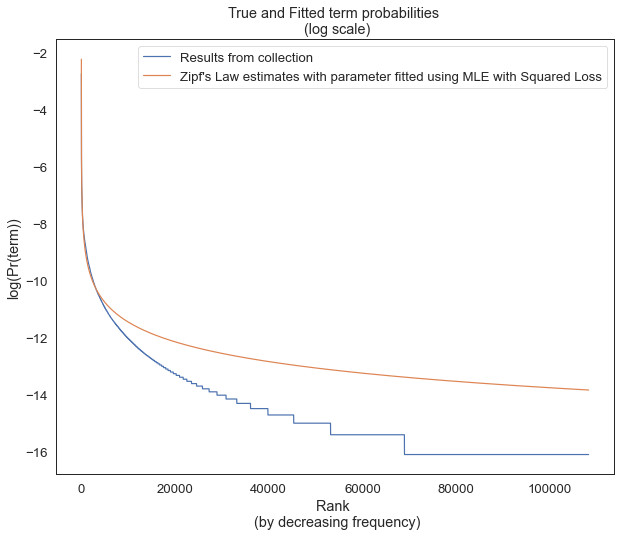

In [20]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(np.log(probabilities), label = "Results from collection")
#ax.plot(np.log(estimates1[:5000]), label = "Zipf's law estimates with parameter c=0.1")
ax.plot(np.log(fitted), label = "Zipf's Law estimates with parameter fitted using MLE with Squared Loss")

plt.xlabel("Rank \n (by decreasing frequency)")
plt.ylabel('log(Pr(term))')
plt.title("True and Fitted term probabilities \n (log scale)")
ax.legend()

In [21]:
data = {'rank': np.arange(1,51), 'term': tokens[:50], 'frequency': frequencies[:50], 'probability': probabilities[:50], 'estimated c': zipfs[:50]}
df = pd.DataFrame(data=data)

In [22]:
df

,rank,term,frequency,probability,estimated c
0,1,the,622418,0.063159,0.063159
1,2,of,333417,0.033833,0.067666
2,3,a,279776,0.028390,0.085169
3,4,and,253503,0.025724,0.102895
4,5,to,239403,0.024293,0.121465
5,6,is,217327,0.022053,0.132317
6,7,in,198951,0.020188,0.141317
7,8,for,107559,0.010914,0.087315
8,9,you,85999,0.008727,0.078539
9,10,or,85215,0.008647,0.086470


In [23]:
residuals = probabilities-fitted.reshape(-1,)

In [24]:
y = np.arange(len(residuals))

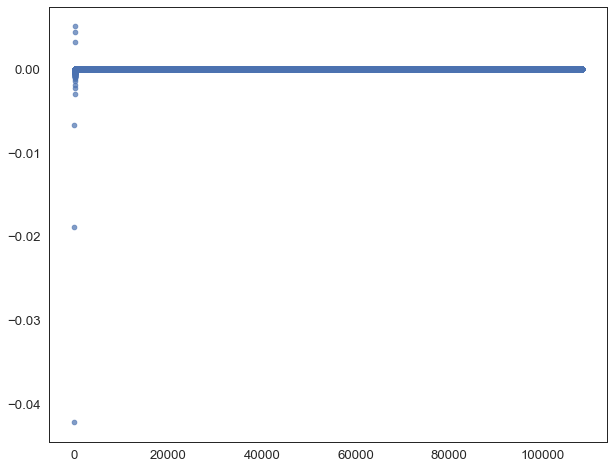

In [25]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter(y, residuals, alpha = 0.7)
plt.plot(np.zeros(shape=len(residuals)))

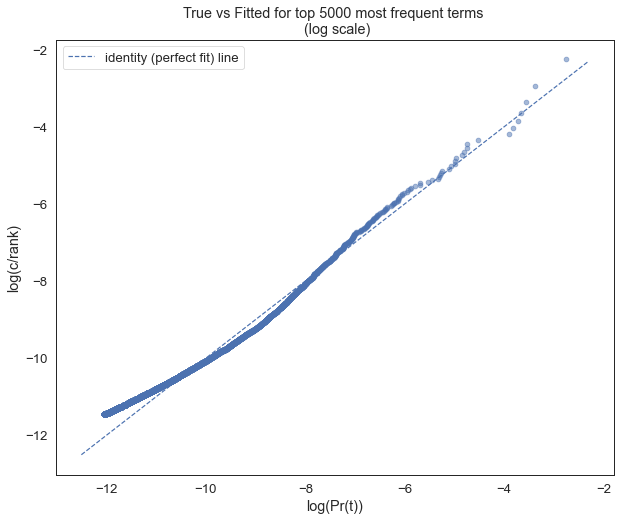

In [26]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter(np.log(probabilities[:10000]), np.log(fitted[:10000].reshape(-1,)),alpha = 0.5)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', label = 'identity (perfect fit) line')
plt.xlabel('log(Pr(t))')
plt.ylabel('log(c/rank)')
plt.title("True vs Fitted for top 5000 most frequent terms \n (log scale)")
ax.legend()

Text(0, 0.5, 'Estimated parameter \n c = Pr(term) * rank')

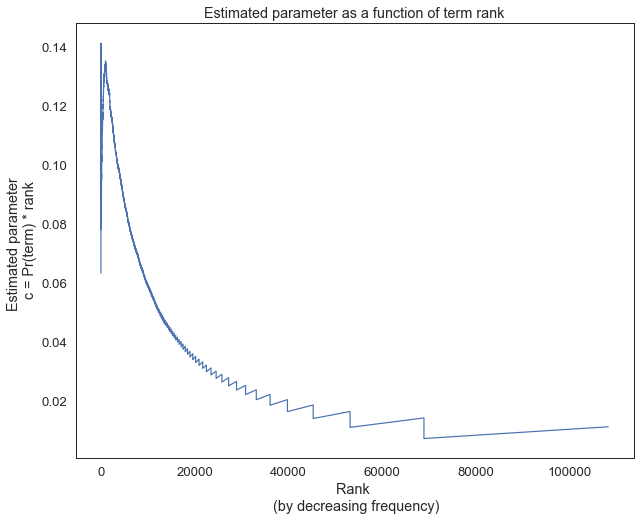

In [27]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(zipfs, label = "Estimated Parameter")
plt.xlabel("Rank \n (by decreasing frequency)")
plt.title("Estimated parameter as a function of term rank")
plt.ylabel("Estimated parameter \n c = Pr(term) * rank")

## Data pre-processing for all other tasks

In [28]:
def preprocess_text(database):
    '''
    using the database as defined in set-up, it preprocesses the text as defined the report 
    '''
    query_filtered = database
    stop_words = nltk.corpus.stopwords.words('english')
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # add ca column with processed and tokanised queries
    query_filtered['tokenised_query'] = query_filtered['query'].str.replace('[\W\d_]', ' ').str.lower()
    query_filtered['tokenised_query'] = query_filtered['tokenised_query'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    query_filtered['tokenised_query'] = query_filtered['tokenised_query'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>1]))
    query_filtered['tokenised_query'] = query_filtered['tokenised_query'].apply(nltk.word_tokenize) 
    query_filtered['tokenised_query'] = query_filtered['tokenised_query'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
    # add a column with processed and tokanised passages
    
    
    query_filtered['tokenised_passage'] = query_filtered['passage'].str.replace('[\W\d_]', ' ').str.lower()
    query_filtered['tokenised_passage'] = query_filtered['tokenised_passage'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    query_filtered['tokenised_passage'] = query_filtered['tokenised_passage'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>1]))
    query_filtered['tokenised_passage'] = query_filtered['tokenised_passage'].apply(nltk.word_tokenize) 
    query_filtered['tokenised_passage'] = query_filtered['tokenised_passage'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
    
    return query_filtered

In [29]:
%%time
database = preprocess_text(candidate)

CPU times: user 1min 41s, sys: 1.14 s, total: 1min 42s
Wall time: 1min 43s


## Inverted index and tf-idf

In [30]:
def process_passage(passage):
    '''
    helper function that takes in a tokanised text (e.g.passage) and returns a list of words and their positions 
    return: {word2: count, word2: count, ....}
    '''
    #get number of tokens
    n = len(passage)
    result = {}
    for i in range(n):
        word = passage[i]
        indices = result.setdefault(word, 0)
        indices += 1
        result[word] = indices
    return result

In [31]:
def get_inverted_index(dataframe, qid):
    '''
    returns an inverted index based on passages corresponding to the qid in the input pandas dataframe where:
            dataframe['tokenised_passage'] stores tokenised version of the passage,
            dataframe['pid'] stores passage id,
            dataframe['qid'] stores query id
    output: {word1: {passage_id1: count, passage_id2: count,... }, word2: {}, ...}
    '''
    # check if the query id is present in the dataframe
    assert qid in dataframe['qid'].values, 'Query id not in the dataframe '
    
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    pid = dataframe['pid'][dataframe['qid']==qid].tolist()
    query = dataframe['tokenised_query'][dataframe['qid']==qid].tolist()[0]
    
    inverted_index = {}
    for i, passage in enumerate(passages):
        # get the dictionary with words and positions for the given passage
        passage_dict = process_passage(passage)
        for token in passage_dict:
            count = passage_dict.get(token) # count of a given word in the passage
            cur_values = inverted_index.setdefault(token, {})
            cur_values[pid[i]] = count
            
    return inverted_index


In [32]:
def get_idf(inverted_index, N):
    '''
    output: {word1: idf1, word2: idf2, ...} for all words in the corpus of query with qid
    with small number added when idf=0 to help with numerical instabilities
    '''
    idf = {}
    
    for term in inverted_index:
        n_docs = len(inverted_index[term])
        term_idf = np.log10(N/n_docs)
        if term_idf ==0:
            term_idf += 1e-10
        idf[term] = term_idf
        
    return idf

In [33]:
def get_tf_idf(dataframe, qid): 
    '''
    caclulates the tf-idf weight for every term corrseponding to qid and creates the vector representations
    output1: {pid1: (vector representation), pid2: (vector representation), ...}
    where vector representation stores tf-idf weights of each term in corpus (0 in term not present)
    output2: query vector reresentation
    '''
    
    assert qid in dataframe['qid'].values, 'Query id not in the dataframe'
    
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    inverted_index = get_inverted_index(dataframe, qid)
    query = dataframe['tokenised_query'][dataframe['qid']==qid].tolist()[0]
    
    # number of documents in the collection
    N = len(passages)
    idf = get_idf(inverted_index, N)
        
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    pid = dataframe['pid'][dataframe['qid']==qid].tolist()
    
    query_processed = process_passage(query)
    # number of documents(passages) in the collection
    N = len(passages)
    # vocabulary size size:
    M = len(inverted_index)
    
    representation = {key: np.zeros(M) for key in pid}
    query_representation = np.zeros(M)
    for m, token in enumerate(inverted_index):
        cur_idf = idf[token]
    
        # update query representation:
        if token in query:
            tf = 1 + np.log(query_processed.get(token))
            score = tf*cur_idf
            query_representation[m] = score
    
        # update representations of all docs listed in the inverted index
        for doc_id in inverted_index[token]:
            tf = 1 + np.log(inverted_index[token].get(doc_id))
            score = tf*cur_idf
            representation[doc_id][m] = score
    
    return representation, query_representation
              

## Vector Space and BM25 Models

In [34]:
def cosine_sim(v, q):
    
    if (np.dot(q, q) <=0) or (np.dot(v,v) <= 0):
        pass
    result = np.dot(v,q) / (np.sqrt(np.dot(v, v)) * np.sqrt(np.dot(q, q)))
    return result

In [35]:
def VS(dataframe, qid):
    passages, query = get_tf_idf(dataframe, qid)
    
    similarities = {}
    for passage in passages:
        vectorised = passages.get(passage)
        sim_score = cosine_sim(query, vectorised)
        similarities[passage] = sim_score
        
    sorted_sim = sorted(similarities.items(), key=lambda value: value[1], reverse=True)
    return sorted_sim

In [36]:
def BM25(dataframe, qid):
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    passage_id = dataframe['pid'][dataframe['qid']==qid].tolist()
    inverted_index = get_inverted_index(dataframe, qid)
    query = dataframe['tokenised_query'][dataframe['qid']==qid].tolist()[0]
    query_processed = process_passage(query)
    # size of collection
    N = len(passages)
    # average document length
    avg_D = np.mean([len(passages[i]) for i in range(len(passages))])
    
    b = 0.75
    k1 = 1.2
    k2 = 100
    
    scores = {}

    for i, pid in enumerate(passage_id):
        estimate = 0
        # document length
        D = len(passages[i])
        K = k1 * ((1-b) + b *(D/avg_D))

        for token, positions in query_processed.items():
            if token not in inverted_index:
                pass
            elif sum(inverted_index[token].values()) == 0:
                   pass
            else:
                q = positions

                r = 0
                R = 0
                # get the number of documents token occurs in
                n = len(inverted_index[token])

                # get the document count for the token
                count = inverted_index[token].get(pid,0)

                cur_estimate = np.log(((r + 0.5) / (R - r + 0.5)) / ((n-r + 0.5)/(N - n - R + r + 0.5)))
                cur_estimate *= ((k1+1)*count)/(K + count)
                cur_estimate *= ((k2 + 1)*q) / (k2 + q)
                estimate += cur_estimate

        scores[pid] = estimate

    sorted_scores = sorted(scores.items(), key=lambda value: value[1], reverse=True)
    
    return sorted_scores

## Language Models with smoothing

In [37]:
def LM_Dirichlet(dataframe, qid):
    
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    passage_id = dataframe['pid'][dataframe['qid']==qid].tolist()
    inverted_index = get_inverted_index(dataframe, qid)
    query = dataframe['tokenised_query'][dataframe['qid']==qid].tolist()[0]
    
    # size of collection
    N = np.sum([len(passages[i]) for i in range(len(passages))])
    
    # number of documents in the collection
    mu = np.mean([len(passages[i]) for i in range(len(passages))])
    
    logs = {}
    
    for i, pid in enumerate(passage_id):
        estimate = 0
        D = len(passages[i])
        lmbda = D /(D+mu)
        
        for token in query:
            if token not in inverted_index:
                pass
            elif sum(inverted_index[token].values()) ==0:
                   pass
            else:
                doc_estimate = 0
                col_estimate = 0

                # get the document probability
                count = inverted_index[token].get(pid,0)
                doc_estimate = lmbda * (count/ D)

                # get the collection probability
                col_estimate = (1-lmbda) * (sum(inverted_index[token].values()) / N)

                # update the overall document log-likelihood with token log-likelihood
                estimate += np.log(doc_estimate + col_estimate)
    
        logs[pid] = estimate

    sorted_logs = sorted(logs.items(), key=lambda value: value[1], reverse=True)
    
    return sorted_logs

In [38]:
def LM_Laplace(dataframe, qid):
    
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    passage_id = dataframe['pid'][dataframe['qid']==qid].tolist()
    inverted_index = get_inverted_index(dataframe, qid)
    query = dataframe['tokenised_query'][dataframe['qid']==qid].tolist()[0]
    
    # size of collection
    N = len(inverted_index)
    
    likelihoods = {}
    
    for i, pid in enumerate(passage_id):
        doc_estimate = 0
        D = len(passages[i])
        for token in query:
            if token not in inverted_index:
                pass
            elif sum(inverted_index[token].values()) ==0:
                   pass
            else:
                # get the document probability
                count = inverted_index[token].get(pid,0)
                doc_estimate += np.log((count+1)/(D + N))
        likelihoods[pid] = doc_estimate
            
    sorted_likelihoods = sorted(likelihoods.items(), key=lambda value: value[1], reverse=True)
    
    return sorted_likelihoods

In [39]:
def LM_Lidstone(dataframe, qid):
    passages = dataframe['tokenised_passage'][dataframe['qid']==qid].tolist()
    passage_id = dataframe['pid'][dataframe['qid']==qid].tolist()
    inverted_index = get_inverted_index(dataframe, qid)
    query = dataframe['tokenised_query'][dataframe['qid']==qid].tolist()[0]
    
    # size of collection
    N = len(inverted_index)
    
    epsilon = 5e-1
    likelihoods = {}
    
    for i, pid in enumerate(passage_id):
        doc_estimate = 0
        D = len(passages[i])
        for token in query:
            if token not in inverted_index:
                pass
            elif sum(inverted_index[token].values()) ==0:
                   pass
            else:
                # get the document probability
                count = inverted_index[token].get(pid,0)
                doc_estimate += np.log((count+epsilon) / (D + epsilon*N))
        likelihoods[pid] = doc_estimate
    
    sorted_likelihoods = sorted(likelihoods.items(), key=lambda value: value[1], reverse=True)
    return sorted_likelihoods

## File writing 

In [40]:
def write_file(dataframe, algoname):
    '''
    writes a .txt file in a format:
    <qid A1 pid rank score algoname>
    '''
    
    f = open(f"{algoname}.txt", "w")
        
    for query in dataframe['qid'].unique():
        # get best 100 passages
        if algoname == "VS":
            scores = VS(dataframe, query)[:100]
        elif algoname == "LM_Dirichlet":
            scores = LM_Dirichlet(dataframe, query)[:100]
        elif algoname == "LM_Laplace":
            scores = LM_Laplace(dataframe, query)[:100]
        elif algoname == "LM_Lidstone":
            scores = LM_Lidstone(dataframe, query)[:100]
        elif algoname == "BM25":
            scores = BM25(dataframe, query)[:100]
        else:
            print("Algorithm name not recognised")
            return
        # write .txt file as requested
        for i, sim in enumerate(scores):
            line = f'{query} A1 {sim[0]} {i + 1} {sim[1]} {algoname} \n'
            f.write(line)          

In [41]:
%%time
# uncomment the below to write the required text file for all algorithms
#algos = ["VS", "BM25", "LM_Dirichlet", "LM_Laplace", "LM_Lidstone"]
#for algoname in algos:
#    write_file(database, algoname)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
